## Goals of this notebook:
- Replicate the experiments presented in the Nips paper
http://papers.nips.cc/paper/6690-detrended-partial-cross-correlation-for-brain-connectivity-analysis

In [11]:
"""
========================================================================
    Copyright (c) 2017, Yale University, Li Lab
                    All Rights Reserved
========================================================================
@DATE (created)       : Wed Mar 15 13:48:45 2017
@DATE (last modified) : 
    2017.03.15 - several experiments
         03.16 - adding feats1005, SMOTE, focus on few classifiers
         03.17 - TODO
                - 1) Validation - [OK]
                - 2) Imbalanced Classes - [ ] 
                    http://contrib.scikit-learn.org/imbalanced-learn/
                - 3) Auto ML - []
                    https://github.com/ClimbsRocks/auto_ml
                - 4) Pylearn2 (Bengio's group) - []
                    https://github.com/lisa-lab/pylearn2

@AUTHOR      : jaime (Contact: jaime.ide@yale.edu)
========================================================================
Description:
    - Test different features
    - Test different classifiers

Ref (related codes):
    - plot_classifier_comparison.py
    - ji_R01_PAR16_Coc_Comparison.py
    - ji_R01_PAR16_Coc_CompClf_DPCCA_nips17.py
    - ji_R01_PAR16_Coc_CompClf_DPCCA_dimReduction.py
    
"""

#runfile('ji_init.py') # Set paths and import essentials

# Imports (It was not cleaned. This is a complete list with more than what is used in this notebook)

#from numpy import *
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from ji_utils_mvpa import *
#import pickle # to save data
from sklearn.preprocessing import StandardScaler # to normalize feats
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# From the original script
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Autoencoder (comment if you are not running autoencoder)
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
# PCA & Isomap
from sklearn import decomposition
from sklearn.manifold import Isomap

h = .02  # step size in the mesh (decision boundary)

# Experiments

### 1) DPCCA+PCA: show the PCA plots and the classification results using DPCCA+PCA

### 2) Baseline: classification results using other features (partial correlation, ICOV, DPCCA peak)

## Experiment 1: DPCCA + PCA

(can choose 'autoencoder' or 'isomap' for the dim. reduction)

In [5]:
# (UPDATE HERE)

# Paths
cpath = os.getcwd()
fpath =  os.path.join(cpath,'0_data','nips17_computed_feats')# UPDATE if necessary (path to the data)
#savepath = fpath

# Models (classifiers) to run
#testset = 1 # Nips 17
testset = 0 # Quick test

# Choose: Dimension reduction
#dimR_method = 'autoencoder' # (note: better to run outside Jupyter for larger number of epochs)
dimR_method = 'pca'
#dimR_method = 'isomap'
#dimR_method = []

Loading data[0]: /home/jaime/Dropbox/jisoft_Lockheed/0_data/nips17_computed_feats/feats270_temporalProfile_75CD88HC.txt 
- Extract PCA for arc# 0  (k=12)...


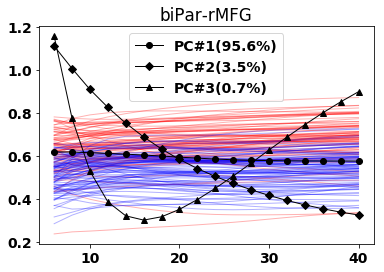

- Extract PCA for arc# 1  (k=12)...


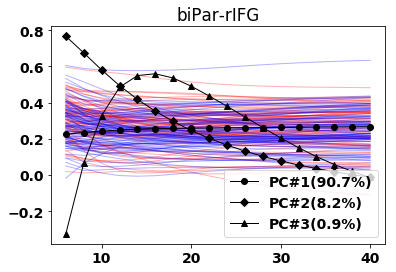

- Extract PCA for arc# 2  (k=12)...


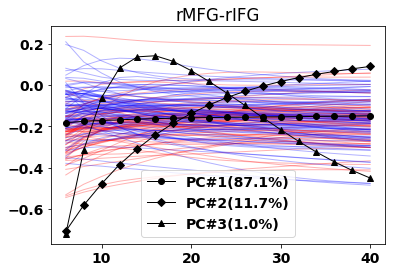

- Extract PCA for arc# 3  (k=12)...


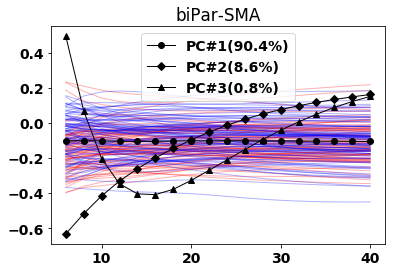

- Extract PCA for arc# 4  (k=12)...


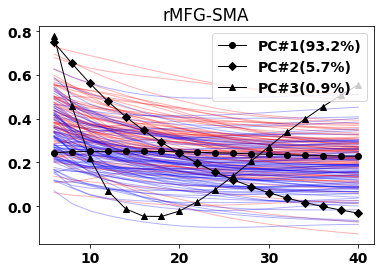

- Extract PCA for arc# 5  (k=12)...


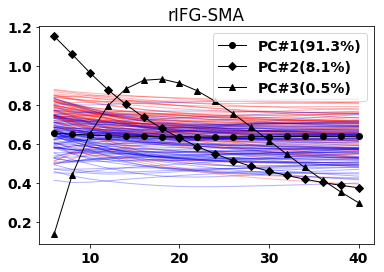

- Extract PCA for arc# 6  (k=12)...


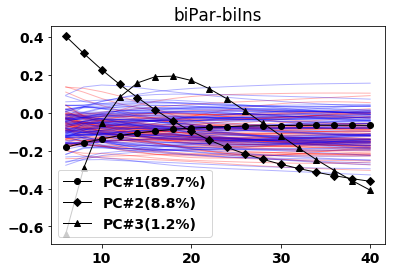

- Extract PCA for arc# 7  (k=12)...


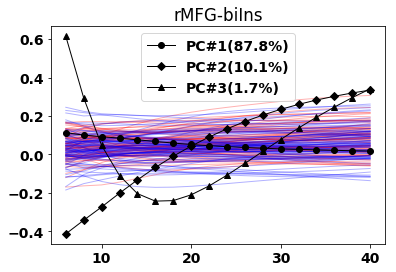

- Extract PCA for arc# 8  (k=12)...


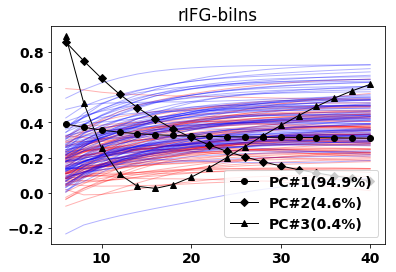

- Extract PCA for arc# 9  (k=12)...


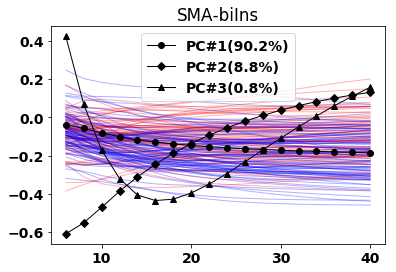

- Extract PCA for arc# 10  (k=12)...


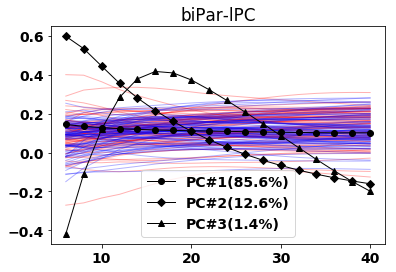

- Extract PCA for arc# 11  (k=12)...


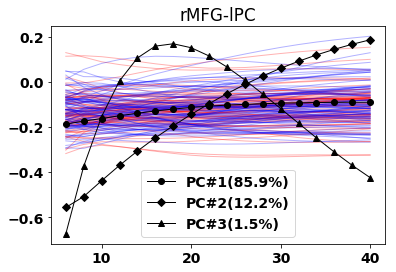

- Extract PCA for arc# 12  (k=12)...


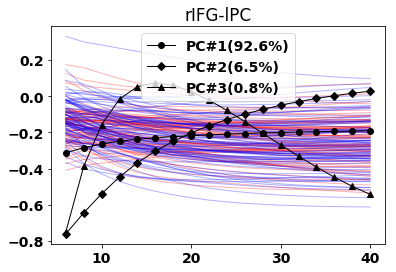

- Extract PCA for arc# 13  (k=12)...


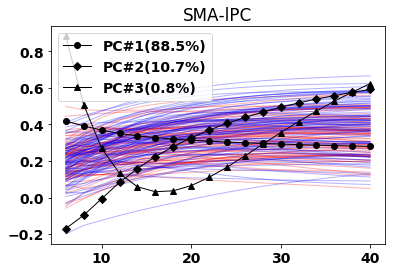

- Extract PCA for arc# 14  (k=12)...


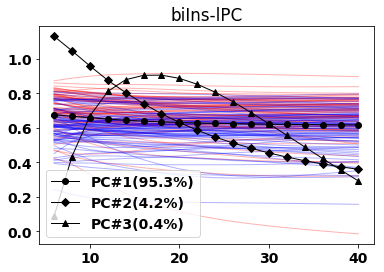

** Running feature: temporalProfile_feats/feats270, Clf: kNN5...
[ 0.64705882  0.58823529  0.88235294  0.82352941  0.76470588  0.875       0.9375
  0.875       0.93333333  0.93333333]
--Results--
             precision    recall  f1-score   support

    Cocaine       0.83      0.79      0.81        75
    Healthy       0.83      0.86      0.84        88

avg / total       0.83      0.83      0.83       163

** Running feature: temporalProfile_feats/feats270, Clf: NBayes...
[ 0.52941176  0.70588235  1.          1.          1.          0.625       0.8125
  1.          1.          0.93333333]
--Results--
             precision    recall  f1-score   support

    Cocaine       0.94      0.87      0.90        75
    Healthy       0.89      0.95      0.92        88

avg / total       0.92      0.91      0.91       163

******** ALL RESULTS ********** (k= 12 )
Options: scale=0 smote=0
Feature 	 ,Classifier 	 ,AUC  	 ,F1 	 ,C1 	 ,C2 	 ,BAcc
temporalProfile_feats/feats270 	 ,kNN5 	 ,0.878182 	 ,

In [8]:
if testset==2:
    names = ["kNN3","kNN5", "LinSVM", "rbfSVM", "GaussianP",
             "DTree", "RForest", "NNet", "AdaBoost",
             "NBayes","QDA"]
    classifiers = [
        KNeighborsClassifier(3),
        KNeighborsClassifier(5),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
if testset==1: # SELECTION
    names = ["kNN3","kNN5", "rbfSVM", "GaussianP",
             "NNet", "AdaBoost","NBayes"]
    classifiers = [ KNeighborsClassifier(3),
        KNeighborsClassifier(5),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB()]
if testset==0: # FOR QUICK TESTING
    names = ["kNN5", "NBayes"]    
    classifiers = [KNeighborsClassifier(3),GaussianNB()]
    #names = ["kNN3","kNN5"]    
    #classifiers = [KNeighborsClassifier(3),KNeighborsClassifier(5)]


# Initialization
options = matlab_like()

# List available files in the folder
file3 = glob.glob(os.path.join(fpath,'feats15_Val_DPCCApeak9_75CD88HC.txt'))
file2 = glob.glob(os.path.join(fpath,'feats270_temporalProfile_75CD88HC.txt'))
file1 = glob.glob(os.path.join(fpath,'feat*_Val*_75CD88HC.txt'))

############## OPTIONS ##############
# Select feature to use
set2use = 1

if set2use==1:
    #allfiles = file3
    allfiles = file2
    #allfiles = file1
    tlabels = ['Cocaine','Healthy']
    savelabel = '75CD88HC_nips17';
    # Select running options
    options.scaleX = 0 # 0 or 1 --> BETTER FOR CORRELATIONS...
    options.run_SMOTE = 0
    
#####################################
allres = [matlab_like_struct()]*(len(allfiles)*len(names)) # Create a list of struct for each feature
featnames = [];

#kall = [1,2,3]
kall = [12] # number of components PCA
compute_all = True        
#for m,i in enumerate(file1):
for k in kall:
    if compute_all:
        cont_res = 0
        for f,i in enumerate(allfiles):
            featname = i.split('_')[-2]+'_'+i.split('_')[-3] # split with separator and get 2nd last part!
            featnames.append(featname)
            #allres[f].clf = [matlab_like_struct()]*len(classifiers) # Create a list of struct for each classifier
            mls_clf = [matlab_like_struct()]*len(classifiers) # Create a list of struct for each classifier
            
            print('Loading data[%d]: %s '%(f,i))
            # This one only works for numbers...
            #cdata = loadtxt(i, delimiter=",")
            
            # Using pandas (good because it loads headers)
            df=pd.read_csv(i, sep=',')
            labels = list(df)
            # Prepare for scikitlearn
            darray = df.values
            XX = darray[:,1:]
            y = darray[:,0].astype(int)        
            
            # Preprocess if requested
            if options.scaleX==1:
                XX = StandardScaler().fit_transform(XX)
            
            nn = 30 # number of neighbors # Used in Isomap
            #k = 6 # number of components or dimensions (autoencoder)
            X = np.zeros([163,k*15])
                            
            if dimR_method == 'isomap':
                k = 9 # best results
                for con in range(15):
                    print('- Extract Isomap for arc#',con,' (k=%d)...'%(k))
                    yes_minmax_scale = False
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    isomap = Isomap(n_neighbors= nn, n_components= k, eigen_solver='auto')
                    #pca.fit(sX)
                    Xout = isomap.fit_transform(sX,y)
                    X[:,k*con:k*(con+1)] = Xout
            
            if dimR_method == 'pca':
                for con in range(15):
                    print('- Extract PCA for arc#',con,' (k=%d)...'%(k))

                    yes_minmax_scale = False
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    pca = decomposition.PCA(n_components=k)
                    
                    #sX = sX - np.mean(sX,axis=0) # MANUAL MEAN CENTERING
                    
                    pca.fit(sX)
                    Xout = pca.transform(sX)
                    X[:,k*con:k*(con+1)] = Xout
                    
                    for i in range(len(sX)):
                        if y[i]==1:
                            plt.plot(range(6,42,2),sX[i,:],linewidth=1.0,alpha=0.3,color='r')
                        if y[i]==2:
                            plt.plot(range(6,42,2),sX[i,:],linewidth=1.0,alpha=0.3,color='b')
                    # PC#1
                    font = {'family' : 'sans-serif','weight' : 'bold','size'   : 14}
                    plt.rc('font', **font)
                    #plt.figure(con+1)
                    # Mean centered component! --> mean(sX)
                    plt.plot(range(6,42,2),pca.components_[0,:]- np.mean(pca.components_[0,:])+np.mean(sX),'k',marker='o',linewidth=1.0,alpha=1,label='PC#1('+ "%2.1f%%" % (pca.explained_variance_ratio_[0]*100) +')')
                    plt.plot(range(6,42,2),pca.components_[1,:]- np.mean(pca.components_[1,:])+np.mean(sX),'k',marker='D',linewidth=1.0,alpha=1,label='PC#2('+ "%2.1f%%" % (pca.explained_variance_ratio_[1]*100) +')')
                    plt.plot(range(6,42,2),pca.components_[2,:]- np.mean(pca.components_[2,:])+np.mean(sX),'k',marker='^',linewidth=1.0,alpha=1,label='PC#3('+ "%2.1f%%" % (pca.explained_variance_ratio_[2]*100) +')')
                    
                    plt.legend()
                    plt.title(labels[con*18+1][:-3])
                    plt.show()
                    plt.legend()
                
            
            if dimR_method == 'autoencoder':
                for con in range(15):
                    k = 2 # best results
                ### AN EXAMPLE OF SIMPLE AUTOENCODER ### - for each connection
                    yes_minmax_scale = True
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    ncol = sX.shape[1]
                    #X_train, X_test, Y_train, Y_test = train_test_split(sX, y, train_size = 0.5, random_state = seed(2017))
                    X_train, X_test, Y_train, Y_test = sX,sX,y,y
                    
                    input_dim = Input(shape = (ncol, ))
                    # DEFINE THE DIMENSION OF ENCODER ASSUMED 3
                    #encoding_dim = 3
                    encoding_dim = k
                    
                    # DEFINE THE ENCODER LAYER
                    encoded = Dense(encoding_dim, activation = 'relu')(input_dim)
                    # DEFINE THE DECODER LAYER
                    decoded = Dense(ncol, activation = 'sigmoid')(encoded)
                    # COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
                    autoencoder = Model(input = input_dim, output = decoded)
                    # CONFIGURE AND TRAIN THE AUTOENCODER
                    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
                    autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
                    #autoencoder.fit(X_train, X_train, nb_epoch = 1000, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
                    
        #            # DEFINE THE ENCODER LAYERS
        #            encoded1 = Dense(20, activation = 'relu')(input_dim)
        #            encoded2 = Dense(10, activation = 'relu')(encoded1)
        #            encoded3 = Dense(5, activation = 'relu')(encoded2)
        #            encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)
        #            # DEFINE THE DECODER LAYERS
        #            decoded1 = Dense(5, activation = 'relu')(encoded4)
        #            decoded2 = Dense(10, activation = 'relu')(decoded1)
        #            decoded3 = Dense(20, activation = 'relu')(decoded2)
        #            decoded4 = Dense(ncol, activation = 'sigmoid')(decoded3)
        #            # COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
        #            autoencoder = Model(input = input_dim, output = decoded4)
        #            # CONFIGURE AND TRAIN THE AUTOENCODER
        #            autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
        #            autoencoder.fit(X_train, X_train, nb_epoch = 100, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
        
                    # THE ENCODER TO EXTRACT THE REDUCED DIMENSION FROM THE ABOVE AUTOENCODER
                    encoder = Model(input = input_dim, output = encoded)
        #           encoder = Model(input = input_dim, output = encoded4)
                    encoded_input = Input(shape = (encoding_dim, ))
                    encoded_out = encoder.predict(X_test)
                    #encoded_out[0:2]
                    X[:,encoding_dim*con:encoding_dim*(con+1)] = encoded_out
            
            if not dimR_method:
                X = XX
            
            if np.any(np.isnan(X)):
                print(X)
                print('Check data! There is a NaN...')
                break
                
            # Define Cross-validation (Stratified Folds based on Class)
            skf = StratifiedKFold(n_splits=10, random_state=1)
            #cv_kX = skf.split(X,y)
            #cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=1)
            
            # iterate over classifiers
            cont = 0
            for name, clf in zip(names, classifiers):
                print('** Running feature: %s, Clf: %s...'%(featname,name))
                #clf.fit(X_train, y_train)
                #score = clf.score(X_test, y_test)
                
                # Validation 
                #   a) k-fold (f1_macro: unweighted F1)
                #c, r = y.shape
                #yaux = y.reshape(c,)
                #scores = cross_val_score(clf,X,y,cv=cv_kX,scoring='f1_macro')
               
                #skf = StratifiedKFold(n_splits=6, random_state=1)
                cv_kX = skf.split(X,y)
                scores = cross_val_score(clf,X,y,cv=cv_kX,scoring='accuracy')
                print(scores)
                
                #   b) Leave-one-out
                ally_pred = [];
                ally_true = [];
                yscores = [];
                loo = LeaveOneOut()
                for train_index, test_index in loo.split(X):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    
                    # SMOTE (regular)
                    if options.run_SMOTE==1:
                        # Apply regular SMOTE
                        sm = SMOTE(kind='regular')
                        X_train, y_train = sm.fit_sample(X_train, y_train)
                        #print('Applied SMOTE... new y_train size:', len(y_train))
                    if options.run_SMOTE==2:
                        # Apply regular SMOTE
                        sm = SMOTE(kind='borderline2',random_state=13) # better
                        #sm = SMOTE(kind='svm')
                        #sm = ADASYN()
                        X_train, y_train = sm.fit_sample(X_train, y_train)
                    
                    # ACTUAL FITTING
                    clf.fit(X_train, y_train)
                    
                    y_pred = clf.predict(X_test)
                    if hasattr(clf, "decision_function"):
                        y_score = clf.fit(X_train,y_train).decision_function(X_test)
                        #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    else: # Use the prediction prob when score is not available
                        y_score = clf.fit(X_train,y_train).predict_proba(X_test)[:,1] 
                        #Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    ally_pred.extend(y_pred)
                    ally_true.extend(y_test)
                    yscores.extend(y_score)
                
                print('--Results--')
                print(classification_report(ally_true, ally_pred, target_names=tlabels))
                Cmatrix = confusion_matrix(ally_true, ally_pred)
                #ji_show_confusion(Cmatrix,tlabels)
                res = ji_get_metrics(Cmatrix)
                
                # ROC
                bally_true = label_binarize(ally_true, classes=[1, 2])
                false_positive_rate, true_positive_rate, thresholds = roc_curve(bally_true, yscores)
                roc_auc = auc(false_positive_rate, true_positive_rate)
                
                # Store results
                allres[cont_res] = res # it stores F1, BAcc, Recall, Precision
                allres[cont_res].AUC = roc_auc
                allres[cont_res].classifier = name
                allres[cont_res].feature = featname
                allres[cont_res].index = [f,cont] # feat# and clf# 
                allres[cont_res].scores = scores
                cont_res+=1
    
                cont+=1

                 
        # Save computed variables
        jires = matlab_like_struct()
        jires.featnames = featnames
        jires.allres = allres
#        sname = 'pickle_clf' + str(len(names)) + '_feats' + str(len(allfiles)) + '_' + 'scale'+ str(options.scaleX)+ '_smote'+ str(options.run_SMOTE) + '_' + savelabel
#        f = open(os.path.join(savepath,sname), 'wb')
#        pickle.dump(jires, f)
#        f.close()
#    else:
#        sname = 'pickle_clf' + str(len(names)) + '_feats' + str(len(allfiles)) +'_'+ 'scale'+ str(options.scaleX) +'_smote'+ str(options.run_SMOTE) +'_'+ savelabel
#        f = open(os.path.join(savepath,sname), 'rb')
#        jires = pickle.load(f)
#        f.close()
#        print('--> Data loaded: ',sname)
#        allres = jires.allres
#        featnames = jires.featnames
    
    # ALL RESULTS
    print('******** ALL RESULTS ********** (k=',k,')')
    #print('******** ALL RESULTS ********** Isomap (k=',k,' nn=',nn,')')
    print('Options: scale=%d smote=%d'%(options.scaleX,options.run_SMOTE))
    print('Feature \t ,Classifier \t ,AUC  \t ,F1 \t ,C1 \t ,C2 \t ,BAcc')
    for res in allres:
        print('%s \t ,%s \t ,%f \t ,%f \t ,%f \t ,%f \t ,%f'%(res.feature,res.classifier,res.AUC,res.F1,res.C1,res.C2,res.BAcc))
    print("")
    
    # CV results
    for res in allres:
        sc = res.scores
        print('%s \t ,%s \t'%(res.feature,res.classifier),end="")
        for v in sc:
            print(",%f \t"%(v),end="")
        print("")

## Experiment 2: Baseline features

In [9]:
# (UPDATE HERE)

# Paths
cpath = os.getcwd()
fpath =  os.path.join(cpath,'0_data','nips17_computed_feats')# UPDATE if necessary (path to the data)
#savepath = fpath

# Models (classifiers) to run
#testset = 1 # Nips 17
testset = 0 # Quick test

# Choose: Dimension reduction
#dimR_method = 'autoencoder' # (note: better to run outside Jupyter for larger number of epochs)
#dimR_method = 'pca'
#dimR_method = 'isomap'
dimR_method = []

In [10]:
if testset==2:
    names = ["kNN3","kNN5", "LinSVM", "rbfSVM", "GaussianP",
             "DTree", "RForest", "NNet", "AdaBoost",
             "NBayes","QDA"]
    classifiers = [
        KNeighborsClassifier(3),
        KNeighborsClassifier(5),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
if testset==1: # SELECTION
    names = ["kNN3","kNN5", "rbfSVM", "GaussianP",
             "NNet", "AdaBoost","NBayes"]
    classifiers = [ KNeighborsClassifier(3),
        KNeighborsClassifier(5),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB()]
if testset==0: # FOR QUICK TESTING
    names = ["kNN5", "NBayes"]    
    classifiers = [KNeighborsClassifier(3),GaussianNB()]
    #names = ["kNN3","kNN5"]    
    #classifiers = [KNeighborsClassifier(3),KNeighborsClassifier(5)]


# Initialization
options = matlab_like()

# List available files in the folder
file3 = glob.glob(os.path.join(fpath,'feats15_Val_DPCCApeak9_75CD88HC.txt'))
file2 = glob.glob(os.path.join(fpath,'feats270_temporalProfile_75CD88HC.txt'))
file1 = glob.glob(os.path.join(fpath,'feat*_Val*_75CD88HC.txt'))

############## OPTIONS ##############
# Select feature to use
set2use = 2

if set2use==1:
    #allfiles = file3
    allfiles = file2
    #allfiles = file1
    tlabels = ['Cocaine','Healthy']
    savelabel = '75CD88HC_nips17';
    # Select running options
    options.scaleX = 0 # 0 or 1 --> BETTER FOR CORRELATIONS...
    options.run_SMOTE = 0
if set2use==2:
    #allfiles = file3
    #allfiles = file2
    allfiles = file1
    tlabels = ['Cocaine','Healthy']
    savelabel = '75CD88HC_nips17';
    # Select running options
    options.scaleX = 0 # 0 or 1 --> BETTER FOR CORRELATIONS...
    options.run_SMOTE = 0
    
#####################################
allres = [matlab_like_struct()]*(len(allfiles)*len(names)) # Create a list of struct for each feature
featnames = [];

#kall = [1,2,3]
kall = [12] # number of components PCA
compute_all = True        
#for m,i in enumerate(file1):
for k in kall:
    if compute_all:
        cont_res = 0
        for f,i in enumerate(allfiles):
            featname = i.split('_')[-2]+'_'+i.split('_')[-3] # split with separator and get 2nd last part!
            featnames.append(featname)
            #allres[f].clf = [matlab_like_struct()]*len(classifiers) # Create a list of struct for each classifier
            mls_clf = [matlab_like_struct()]*len(classifiers) # Create a list of struct for each classifier
            
            print('Loading data[%d]: %s '%(f,i))
            # This one only works for numbers...
            #cdata = loadtxt(i, delimiter=",")
            
            # Using pandas (good because it loads headers)
            df=pd.read_csv(i, sep=',')
            labels = list(df)
            # Prepare for scikitlearn
            darray = df.values
            XX = darray[:,1:]
            y = darray[:,0].astype(int)        
            
            # Preprocess if requested
            if options.scaleX==1:
                XX = StandardScaler().fit_transform(XX)
            
            nn = 30 # number of neighbors # Used in Isomap
            #k = 6 # number of components or dimensions (autoencoder)
            X = np.zeros([163,k*15])
                            
            if dimR_method == 'isomap':
                k = 9 # best results
                for con in range(15):
                    print('- Extract Isomap for arc#',con,' (k=%d)...'%(k))
                    yes_minmax_scale = False
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    isomap = Isomap(n_neighbors= nn, n_components= k, eigen_solver='auto')
                    #pca.fit(sX)
                    Xout = isomap.fit_transform(sX,y)
                    X[:,k*con:k*(con+1)] = Xout
            
            if dimR_method == 'pca':
                for con in range(15):
                    print('- Extract PCA for arc#',con,' (k=%d)...'%(k))

                    yes_minmax_scale = False
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    pca = decomposition.PCA(n_components=k)
                    
                    #sX = sX - np.mean(sX,axis=0) # MANUAL MEAN CENTERING
                    
                    pca.fit(sX)
                    Xout = pca.transform(sX)
                    X[:,k*con:k*(con+1)] = Xout
                    
                    for i in range(len(sX)):
                        if y[i]==1:
                            plt.plot(range(6,42,2),sX[i,:],linewidth=1.0,alpha=0.3,color='r')
                        if y[i]==2:
                            plt.plot(range(6,42,2),sX[i,:],linewidth=1.0,alpha=0.3,color='b')
                    # PC#1
                    font = {'family' : 'sans-serif','weight' : 'bold','size'   : 14}
                    plt.rc('font', **font)
                    #plt.figure(con+1)
                    # Mean centered component! --> mean(sX)
                    plt.plot(range(6,42,2),pca.components_[0,:]- np.mean(pca.components_[0,:])+np.mean(sX),'k',marker='o',linewidth=1.0,alpha=1,label='PC#1('+ "%2.1f%%" % (pca.explained_variance_ratio_[0]*100) +')')
                    plt.plot(range(6,42,2),pca.components_[1,:]- np.mean(pca.components_[1,:])+np.mean(sX),'k',marker='D',linewidth=1.0,alpha=1,label='PC#2('+ "%2.1f%%" % (pca.explained_variance_ratio_[1]*100) +')')
                    plt.plot(range(6,42,2),pca.components_[2,:]- np.mean(pca.components_[2,:])+np.mean(sX),'k',marker='^',linewidth=1.0,alpha=1,label='PC#3('+ "%2.1f%%" % (pca.explained_variance_ratio_[2]*100) +')')
                    
                    plt.legend()
                    plt.title(labels[con*18+1][:-3])
                    plt.show()
                    plt.legend()
                
            
            if dimR_method == 'autoencoder':
                for con in range(15):
                    k = 2 # best results
                ### AN EXAMPLE OF SIMPLE AUTOENCODER ### - for each connection
                    yes_minmax_scale = True
                    if yes_minmax_scale:
                        sX = minmax_scale(XX[:,con*18:(con+1)*18], axis = 0)
                    else:
                        sX = XX[:,con*18:(con+1)*18]
                        
                    ncol = sX.shape[1]
                    #X_train, X_test, Y_train, Y_test = train_test_split(sX, y, train_size = 0.5, random_state = seed(2017))
                    X_train, X_test, Y_train, Y_test = sX,sX,y,y
                    
                    input_dim = Input(shape = (ncol, ))
                    # DEFINE THE DIMENSION OF ENCODER ASSUMED 3
                    #encoding_dim = 3
                    encoding_dim = k
                    
                    # DEFINE THE ENCODER LAYER
                    encoded = Dense(encoding_dim, activation = 'relu')(input_dim)
                    # DEFINE THE DECODER LAYER
                    decoded = Dense(ncol, activation = 'sigmoid')(encoded)
                    # COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
                    autoencoder = Model(input = input_dim, output = decoded)
                    # CONFIGURE AND TRAIN THE AUTOENCODER
                    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
                    autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
                    #autoencoder.fit(X_train, X_train, nb_epoch = 1000, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
                    
        #            # DEFINE THE ENCODER LAYERS
        #            encoded1 = Dense(20, activation = 'relu')(input_dim)
        #            encoded2 = Dense(10, activation = 'relu')(encoded1)
        #            encoded3 = Dense(5, activation = 'relu')(encoded2)
        #            encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)
        #            # DEFINE THE DECODER LAYERS
        #            decoded1 = Dense(5, activation = 'relu')(encoded4)
        #            decoded2 = Dense(10, activation = 'relu')(decoded1)
        #            decoded3 = Dense(20, activation = 'relu')(decoded2)
        #            decoded4 = Dense(ncol, activation = 'sigmoid')(decoded3)
        #            # COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
        #            autoencoder = Model(input = input_dim, output = decoded4)
        #            # CONFIGURE AND TRAIN THE AUTOENCODER
        #            autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
        #            autoencoder.fit(X_train, X_train, nb_epoch = 100, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))
        
                    # THE ENCODER TO EXTRACT THE REDUCED DIMENSION FROM THE ABOVE AUTOENCODER
                    encoder = Model(input = input_dim, output = encoded)
        #           encoder = Model(input = input_dim, output = encoded4)
                    encoded_input = Input(shape = (encoding_dim, ))
                    encoded_out = encoder.predict(X_test)
                    #encoded_out[0:2]
                    X[:,encoding_dim*con:encoding_dim*(con+1)] = encoded_out
            

            if not dimR_method:
                X = XX
            
            if np.any(np.isnan(X)):
                print(X)
                print('Check data! There is a NaN...')
                PARE
            

                
            # Define Cross-validation (Stratified Folds based on Class)
            skf = StratifiedKFold(n_splits=10, random_state=1)
            #cv_kX = skf.split(X,y)
            #cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=1)
            
            # iterate over classifiers
            cont = 0
            for name, clf in zip(names, classifiers):
                print('** Running feature: %s, Clf: %s...'%(featname,name))
                #clf.fit(X_train, y_train)
                #score = clf.score(X_test, y_test)
                
                # Validation 
                #   a) k-fold (f1_macro: unweighted F1)
                #c, r = y.shape
                #yaux = y.reshape(c,)
                #scores = cross_val_score(clf,X,y,cv=cv_kX,scoring='f1_macro')
               
                #skf = StratifiedKFold(n_splits=6, random_state=1)
                cv_kX = skf.split(X,y)
                scores = cross_val_score(clf,X,y,cv=cv_kX,scoring='accuracy')
                print(scores)
                
                #   b) Leave-one-out
                ally_pred = [];
                ally_true = [];
                yscores = [];
                loo = LeaveOneOut()
                for train_index, test_index in loo.split(X):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    
                    # SMOTE (regular)
                    if options.run_SMOTE==1:
                        # Apply regular SMOTE
                        sm = SMOTE(kind='regular')
                        X_train, y_train = sm.fit_sample(X_train, y_train)
                        #print('Applied SMOTE... new y_train size:', len(y_train))
                    if options.run_SMOTE==2:
                        # Apply regular SMOTE
                        sm = SMOTE(kind='borderline2',random_state=13) # better
                        #sm = SMOTE(kind='svm')
                        #sm = ADASYN()
                        X_train, y_train = sm.fit_sample(X_train, y_train)
                    
                    # ACTUAL FITTING
                    clf.fit(X_train, y_train)
                    
                    y_pred = clf.predict(X_test)
                    if hasattr(clf, "decision_function"):
                        y_score = clf.fit(X_train,y_train).decision_function(X_test)
                        #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    else: # Use the prediction prob when score is not available
                        y_score = clf.fit(X_train,y_train).predict_proba(X_test)[:,1] 
                        #Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    ally_pred.extend(y_pred)
                    ally_true.extend(y_test)
                    yscores.extend(y_score)
                
                print('--Results--')
                print(classification_report(ally_true, ally_pred, target_names=tlabels))
                Cmatrix = confusion_matrix(ally_true, ally_pred)
                #ji_show_confusion(Cmatrix,tlabels)
                res = ji_get_metrics(Cmatrix)
                
                # ROC
                bally_true = label_binarize(ally_true, classes=[1, 2])
                false_positive_rate, true_positive_rate, thresholds = roc_curve(bally_true, yscores)
                roc_auc = auc(false_positive_rate, true_positive_rate)
                
                # Store results
                allres[cont_res] = res # it stores F1, BAcc, Recall, Precision
                allres[cont_res].AUC = roc_auc
                allres[cont_res].classifier = name
                allres[cont_res].feature = featname
                allres[cont_res].index = [f,cont] # feat# and clf# 
                allres[cont_res].scores = scores
                cont_res+=1
    
                cont+=1

                 
        # Save computed variables
        jires = matlab_like_struct()
        jires.featnames = featnames
        jires.allres = allres
#        sname = 'pickle_clf' + str(len(names)) + '_feats' + str(len(allfiles)) + '_' + 'scale'+ str(options.scaleX)+ '_smote'+ str(options.run_SMOTE) + '_' + savelabel
#        f = open(os.path.join(savepath,sname), 'wb')
#        pickle.dump(jires, f)
#        f.close()
#    else:
#        sname = 'pickle_clf' + str(len(names)) + '_feats' + str(len(allfiles)) +'_'+ 'scale'+ str(options.scaleX) +'_smote'+ str(options.run_SMOTE) +'_'+ savelabel
#        f = open(os.path.join(savepath,sname), 'rb')
#        jires = pickle.load(f)
#        f.close()
#        print('--> Data loaded: ',sname)
#        allres = jires.allres
#        featnames = jires.featnames
    
    # ALL RESULTS
    print('******** ALL RESULTS ********** (k=',k,')')
    #print('******** ALL RESULTS ********** Isomap (k=',k,' nn=',nn,')')
    print('Options: scale=%d smote=%d'%(options.scaleX,options.run_SMOTE))
    print('Feature \t ,Classifier \t ,AUC  \t ,F1 \t ,C1 \t ,C2 \t ,BAcc')
    for res in allres:
        print('%s \t ,%s \t ,%f \t ,%f \t ,%f \t ,%f \t ,%f'%(res.feature,res.classifier,res.AUC,res.F1,res.C1,res.C2,res.BAcc))
    print("")
    
    # CV results
    for res in allres:
        sc = res.scores
        print('%s \t ,%s \t'%(res.feature,res.classifier),end="")
        for v in sc:
            print(",%f \t"%(v),end="")
        print("")

Loading data[0]: /home/jaime/Dropbox/jisoft_Lockheed/0_data/nips17_computed_feats/feats15_Val_DPCCApeak9_75CD88HC.txt 
** Running feature: DPCCApeak9_Val, Clf: kNN5...
[ 0.76470588  0.70588235  0.82352941  0.88235294  0.82352941  0.75        0.875
  0.875       0.86666667  0.66666667]
--Results--
             precision    recall  f1-score   support

    Cocaine       0.79      0.75      0.77        75
    Healthy       0.79      0.83      0.81        88

avg / total       0.79      0.79      0.79       163

** Running feature: DPCCApeak9_Val, Clf: NBayes...
[ 0.64705882  0.70588235  0.70588235  0.76470588  0.70588235  0.75        0.9375
  0.9375      0.93333333  0.86666667]
--Results--
             precision    recall  f1-score   support

    Cocaine       0.81      0.81      0.81        75
    Healthy       0.84      0.84      0.84        88

avg / total       0.83      0.83      0.83       163

Loading data[1]: /home/jaime/Dropbox/jisoft_Lockheed/0_data/nips17_computed_feats/feats15_